## Q4 Cultural Clocks: How Global Holidays Shape Movie Releases and Success
Yet the film doesn’t just target one market—it aims for global appeal. Annabel compares international release data, discovering that movies tapping into local holiday seasons or festivals often double their earnings. In some countries, family comedies thrive during winter celebrations; in others, epic dramas shine during national remembrance days. By tailoring international release dates around cultural “clocks,” the studio can secure strong openings overseas, reinforcing the film’s global performance before it even hits the domestic market.

In [31]:
import pandas as pd 
import numpy as np 
import re 
import seaborn as sns
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup 
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px
import ast


In [32]:
folder = "generated/"

df_movies=pd.read_csv(folder + "USE_THIS_DATASET.csv", index_col = 'Wikipedia movie ID')

#clean the data

df_movies = df_movies.dropna(subset=['Movie release date'])
df_movies = df_movies.dropna(subset=['Movie box office revenue'])
df_movies = df_movies.dropna(subset=['Theme'])
df_movies = df_movies.dropna(subset=['Movie genres'])

df_movies.head()


,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,Sentiment,Compound Score,Theme,vote_average,budget
Wikipedia movie ID,,,,,,,,,,,,,,,
975900,Ghosts of Mars,8.0,2001.0,2001-08-24,2.477118e+07,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Set in the second half of the 22nd century, th...",negative,-0.9913,Survival,5.127,4.950406e+07
10408933,Alexander's Ragtime Band,8.0,1938.0,1938-08-16,7.619573e+07,106.0,['English'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']","Classical violinist, Roger Grant disappoints h...",positive,0.8873,Love,6.600,4.233096e+07
171005,Henry V,11.0,1989.0,1989-11-08,2.614955e+07,137.0,['English'],['United Kingdom'],"['Costume drama', 'War film', 'Epic', 'Period ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,positive,0.3182,Union,7.214,2.316146e+07
77856,Mary Poppins,8.0,1964.0,1964-08-27,1.016281e+09,139.0,['English'],['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",The film opens with Mary Poppins perched in a...,positive,0.9945,Magic,7.569,5.962185e+07
612710,New Rose Hotel,10.0,1999.0,1999-10-01,4.020839e+04,92.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Future noir',...",A corporate raider and his henchman use a chan...,neutral,0.0000,Betrayal,5.270,NaN


X-axis: Years
Y-axis: Total Annual Box Office Revenue for Relevant Genres/Themes
Place markers or vertical lines to denote major historical events (wars, elections, social movements).
Annotations explain spikes or dips correlating with those events.


Movie release year
1970-01-01 00:00:00.000001970    1.003859e+12
Name: Movie box office revenue, dtype: float64


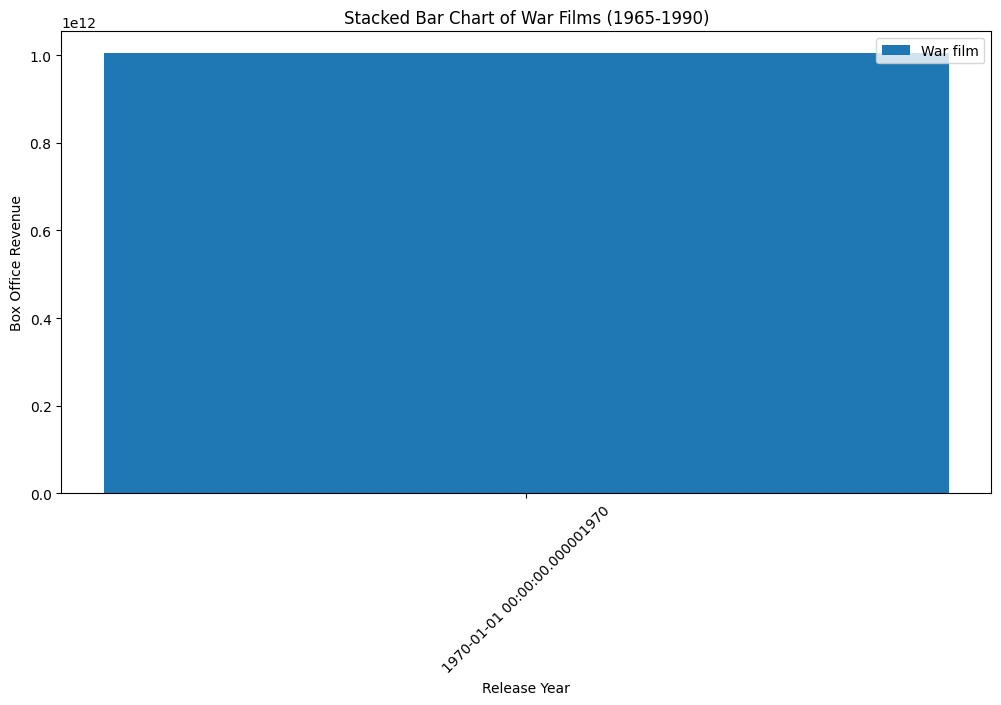

In [52]:
df_movies['Movie release year'] = pd.to_datetime(df_movies['Movie release year'], errors='coerce')

# Filter movies between 1965 and 1990
filtered_movies = df_movies[
    (df_movies['Movie release year'].dt.year > 1965) & (df_movies['Movie release year'].dt.year < 1990)
]

# Further filter by genre
war_movies = filtered_movies[filtered_movies['Movie genres'] == 'War film']

# Group by 'Year' and calculate total box office revenue
stacked_data = filtered_movies.groupby('Movie release year')['Movie box office revenue'].sum()


print(stacked_data)

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(stacked_data.index, stacked_data.values, label='War film')
plt.xlabel('Release Year')
plt.ylabel('Box Office Revenue')
plt.title('Stacked Bar Chart of War Films (1965-1990)')
plt.xticks(ticks=stacked_data.index, labels=stacked_data.index, rotation=45)
plt.legend()
plt.show()

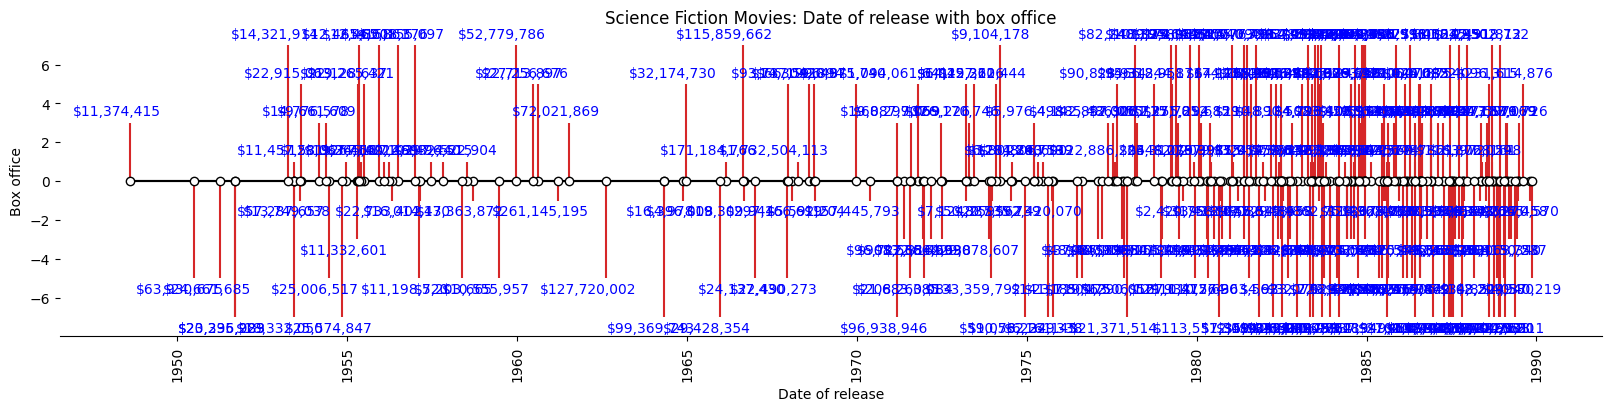

In [34]:
# Parse string representations of lists into actual lists
df_movies['Movie genres'] = df_movies['Movie genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Ensure 'Movie release date' is datetime
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')

# Filter for movies containing 'Science Fiction' in genres
filtered_movies = df_movies[
    df_movies['Movie genres'].apply(lambda genres: 'Science Fiction' in genres if isinstance(genres, list) else False)
    & (df_movies['Movie release date'] > pd.Timestamp('1947-03-12'))        # WWII 1939-09-01 to 1945-09-02
    & (df_movies['Movie release date'] < pd.Timestamp('1989-12-03'))        # Cold War 1947-03-12 to 1989-12-03
]

# Extract timelines and box office data
timelines = filtered_movies['Movie release date'].tolist()
box_office = filtered_movies['Movie box office revenue'].tolist()

# Define levels for vertical lines
levels = np.tile([-7, 7, -5, 5, -3, 3, -1, 1], int(np.ceil(len(timelines) / 8)))[:len(timelines)]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
ax.set(title="Science Fiction Movies: Date of release with box office",
       xlabel="Date of release", ylabel="Box office")

# Add vertical lines and points
ax.vlines(timelines, 0, levels, color='tab:red')
ax.plot(timelines, np.zeros_like(timelines), "-o", color="k", markerfacecolor="w")

# Add annotations
for t, l, b in zip(timelines, levels, box_office):
    ax.annotate(f"${b:,.0f}", xy=(t, l),
                xytext=(22, np.sign(l) * 3), textcoords='offset points',
                horizontalalignment='right',
                verticalalignment='bottom' if l > 0 else 'top',
                color='blue')

# Customize axes
ax.yaxis.set_visible(True)  # Show y-axis
ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines['bottom'].set_position(('data', -8))

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

# Show plot
plt.show()


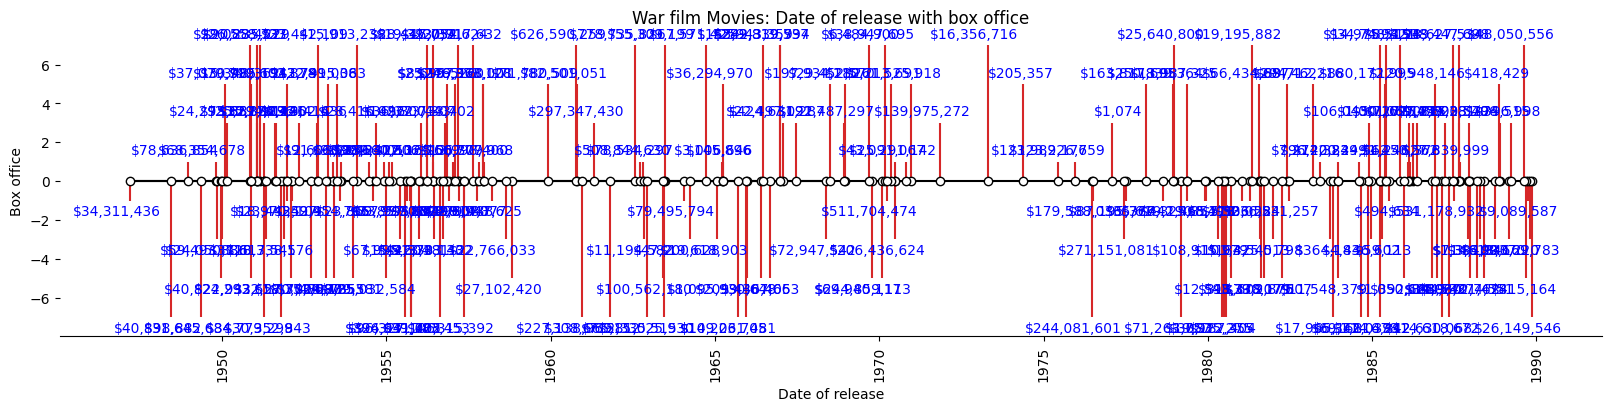

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ast

# Parse string representations of lists into actual lists
df_movies['Movie genres'] = df_movies['Movie genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Ensure 'Movie release date' is datetime
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')

# Filter for movies containing 'Science Fiction' in genres
filtered_movies = df_movies[
    df_movies['Movie genres'].apply(lambda genres: 'War film' in genres if isinstance(genres, list) else False)
    & (df_movies['Movie release date'] > pd.Timestamp('1947-03-12'))        # WWII 1939-09-01 to 1945-09-02
    & (df_movies['Movie release date'] < pd.Timestamp('1989-12-03'))        # Cold War 1947-03-12 to 1989-12-03
]

# Extract timelines and box office data
timelines = filtered_movies['Movie release date'].tolist()
box_office = filtered_movies['Movie box office revenue'].tolist()

# Define levels for vertical lines
levels = np.tile([-7, 7, -5, 5, -3, 3, -1, 1], int(np.ceil(len(timelines) / 8)))[:len(timelines)]

# Create the plot
fig, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
ax.set(title="War film Movies: Date of release with box office",
       xlabel="Date of release", ylabel="Box office")

# Add vertical lines and points
ax.vlines(timelines, 0, levels, color='tab:red')
ax.plot(timelines, np.zeros_like(timelines), "-o", color="k", markerfacecolor="w")

# Add annotations
for t, l, b in zip(timelines, levels, box_office):
    ax.annotate(f"${b:,.0f}", xy=(t, l),
                xytext=(22, np.sign(l) * 3), textcoords='offset points',
                horizontalalignment='right',
                verticalalignment='bottom' if l > 0 else 'top',
                color='blue')

# Customize axes
ax.yaxis.set_visible(True)  # Show y-axis
ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines['bottom'].set_position(('data', -8))

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

# Show plot
plt.show()


In [36]:

# plt.title("box office revenue of War film movies")
# plt.xlabel("Decade")
# plt.ylabel("Box office revenue")
# plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()